In [1]:
#Prepared by : Shamima Rashid, Nanyang Technological University, Singapore. 30May2023. last modified Nov. 2023
#This notebook was prepared with the help of the following codes:

#1. protein_topk_pool.py (PYG Library, pytorch Team)
#2. https://github.com/DeepGraphLearning/GraphLoG/dataloader.py. 
#3. https://github.com/BaratiLab/Potential-Neutralizing-antibodies-discovered-for-novel-corona-virus-using-machine-learning/blob/master/Ab_Virus.py

# Using 6 RDKit Features


In [2]:
import pandas as pd
import numpy as np
import torch

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
#from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

import torch_geometric
import torch.nn.functional as F
from torch.utils import data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv #TopKPooling
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap

from layers import SAGPool

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score,  roc_curve, roc_auc_score, matthews_corrcoef, precision_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [ ]:
!pip install mitdeeplearning

In [5]:
import mitdeeplearning as mdl
import time
import functools

from IPython import display as ipythondisplay
from tqdm import tqdm

In [6]:
#!nvidia-smi #Valid only for systems with Nvidia Graphics

In [7]:
# Dataset file here
fn2 = 'data/CoV-AbDab_310.csv'

df = pd.read_csv(fn2)

Class
0     82
1    228
dtype: int64


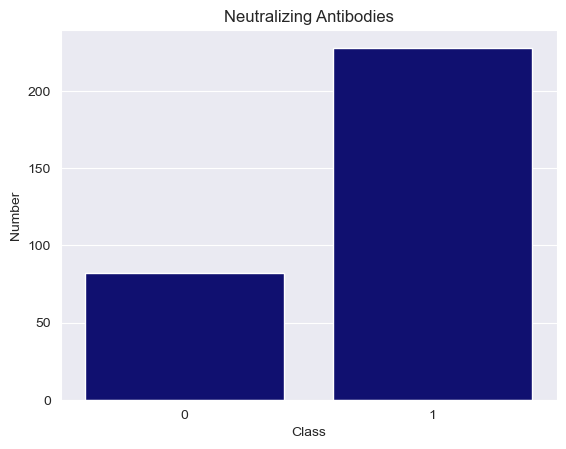

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.head(5)


##Target Variable countplot
sns.set_style('darkgrid')

p = sns.countplot(x ='Class', data=df, color='navy').set(title='Neutralizing Antibodies', ylabel= 'Number', xlabel='Class')
print(df.groupby('Class').size())


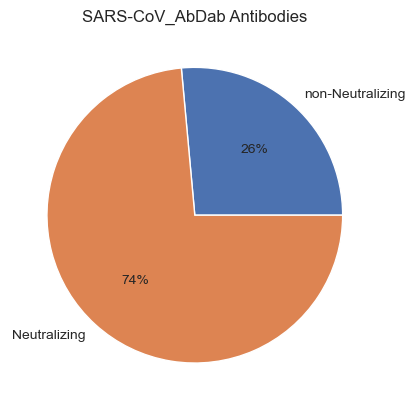

In [9]:
ab_data = [82, 228]
#ab_data = [82, 8]
ab_labels = ['non-Neutralizing', 'Neutralizing']
colors = sns.color_palette('deep')

plt.pie(ab_data, labels=ab_labels, colors=colors, autopct="%.0f%%")
plt.title("SARS-CoV_AbDab Antibodies")

plt.savefig('Antibodies.png')
plt.show()

In [10]:
#Debug
#check for non-standard aa

AA = ['I','V','L','F','C', 'M','A','G','T','W','S','Y','P','H','E',
    'Q','D','N','K','R']


for i in range (len(df['Paratope'])):
    P = df['Paratope'].loc[i]
    for res in P:
        if res not in AA:
            print(i, res, P)

In [11]:
for j in range (len(df['Epitope'])):
    E = df['Epitope'].loc[i]
    for res in E:
        if res not in AA:
            print(j, res, E)
            

In [12]:
## Paratope - part of an antibody
mol_ab = []
for i in range (len(df['Paratope'])):
    mol = Chem.MolFromFASTA(df['Paratope'].loc[i])
    mol_ab.append(mol)
print(len(mol_ab))

## Epitope - part of the antigen
mol_an = []
for i in range (len(df['Epitope'])):
    mol = Chem.MolFromFASTA(df['Epitope'].loc[i])
    mol_an.append(mol)
print(len(mol_an))

310
310


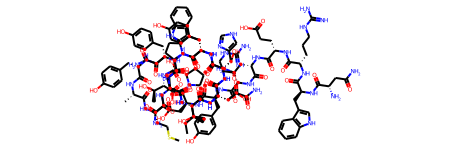

In [13]:
#Visualize with RDKit
mol_ab[3]

In [14]:
#Y = df['Class']
Y = torch.tensor(df['Class'].values, dtype=torch.long) #int64
#Y = torch.tensor(df['Class'].values, dtype=torch.float) #float32
Y = Y.unsqueeze(dim=1)
#Y.shape


In [15]:
X = torch.rand(310,1)
#X.shape

In [16]:
#check the proportion of classes in stratified train and test
#Save train and test indices into numpy arrays, respectively. Work with list indices in torch geometric data library

CV_train_idx =[]
CV_test_idx = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


for train_idx, test_idx in skf.split(X,Y):
    #print(train_idx, "\n\n", test_idx)
    #print(type(train_idx))
    CV_train_idx.append(train_idx)
    CV_test_idx.append(test_idx)
    
    #t1=torch.from_numpy((train_idx)) #train_idx in torch.tensor form
    #t2=torch.from_numpy((test_idx)) #test_idx in torch.tensor form
    #itrain = torch.index_select(Y, 0, t1).numpy() #.squeeze()
    #itest = torch.index_select(Y, 0, t2).numpy()  #.squeeze
    
    #CV_train_idx.append(itrain)
    #CV_test_idx.append(itest)
    

In [17]:
#print train/test indices if needed

# for i in range(len(CV_train_idx)):
#     print(i, "\n")
#     print("Train_ID: ", CV_train_idx[i])
#     print("Test_ID: ", CV_test_idx[i])
#     print("\n")

In [18]:
# allowable node and edge features
allowable_features = {
    'possible_atomic_num_list' : list(range(1, 119)),
    'possible_formal_charge_list' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'possible_chirality_list' : [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ],
    'possible_hybridization_list' : [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED
    ],
    'possible_numH_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'possible_implicit_valence_list' : [0, 1, 2, 3, 4, 5, 6],
    'possible_degree_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'possible_aromatic' :[True, False],
    'possible_bonds' : [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ],
    'possible_bond_dirs' : [ # only for double bond stereo information
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ]
}

In [19]:
def mol_to_graph_data_obj_simple(mol):
    """
    Converts rdkit mol object to graph Data object required by the pytorch
    geometric package. NB: Uses simplified atom and bond features, and represent
    as indices
    :param mol: rdkit mol object
    :return: graph data object with the attributes: x, edge_index, edge_attr
    """
    # atoms
    #num_atom_features = 2   # atom type,  chirality tag
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_feature = ([allowable_features['possible_atomic_num_list'].index(atom.GetAtomicNum())] +  
                       #[allowable_features['possible_chirality_list'].index(atom.GetChiralTag())] + \
                       #[allowable_features['possible_formal_charge_list'].index(atom.GetFormalCharge())]+ 
                       [allowable_features['possible_hybridization_list'].index(atom.GetHybridization())] + 
                       [allowable_features['possible_numH_list'].index(atom.GetTotalNumHs())] + 
                       [allowable_features['possible_implicit_valence_list'].index(atom.GetImplicitValence())] + 
                       [allowable_features['possible_degree_list'].index(atom.GetDegree())] + 
                       [allowable_features['possible_aromatic'].index(atom.GetIsAromatic())]) 
                        
        atom_features_list.append(atom_feature)
    x = torch.tensor(np.array(atom_features_list), dtype=torch.float) #torch.long
    #one hot encoding

    # bonds
    num_bond_features = 2   # bond type, bond direction
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_feature = [allowable_features['possible_bonds'].index(
                bond.GetBondType())] + [allowable_features[
                                            'possible_bond_dirs'].index(
                bond.GetBondDir())]
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = torch.tensor(np.array(edges_list).T, dtype=torch.long)

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = torch.tensor(np.array(edge_features_list),
                                 dtype=torch.float)#torch.long
    else:   # mol has no bonds
        edge_index = torch.empty((2, 0), dtype=torch.long)#torch.long
        edge_attr = torch.empty((0, num_bond_features), dtype=torch.float)#torch.long
 
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data


In [20]:
class PairData(Data):
    def __init__(self, edge_index_ab=None, x_ab=None, edge_index_an=None, x_an=None, y=None):
        super().__init__()
        self.edge_index_ab = edge_index_ab
        self.x_ab = x_ab
        self.edge_index_an = edge_index_an
        self.x_an = x_an
        self.y = y
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_ab':
            return self.x_ab.size(0)
        if key == 'edge_index_an':
            return self.x_an.size(0)
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [21]:
graph_ab = []

for m in range (len(mol_ab)):
    graph = mol_to_graph_data_obj_simple(mol_ab[m])
    #graph.y = Y[m]
    graph_ab.append(graph)
print(len(graph_ab))


graph_an = []

for k in range (len(mol_an)):
    graph = mol_to_graph_data_obj_simple(mol_an[k])
    graph_an.append(graph)
print(len(graph_an))


310
310


In [22]:
# for g in graph_ab:
#     print(g.x[:,0])
print(graph_an[1].x, "\n\n", graph_ab[1].x)
#print(graph_an[0].x[:,0])


tensor([[6., 3., 2., 2., 1., 1.],
        [5., 3., 1., 1., 3., 1.],
        [5., 2., 0., 0., 3., 1.],
        ...,
        [7., 2., 0., 0., 1., 1.],
        [6., 2., 2., 2., 1., 1.],
        [7., 2., 1., 1., 1., 1.]]) 

 tensor([[6., 3., 2., 2., 1., 1.],
        [5., 3., 1., 1., 3., 1.],
        [5., 2., 0., 0., 3., 1.],
        ...,
        [5., 2., 1., 1., 2., 0.],
        [5., 2., 1., 1., 2., 0.],
        [7., 2., 1., 1., 1., 1.]])


In [23]:
class Net(torch.nn.Module):
    def __init__(self, num_features, units):
        super().__init__()

        #self.conv1 = GraphConv(dataset[0].x.num_features, 128)
        self.conv1 = GraphConv(num_features, units)
        self.pool1 = SAGPool(units, ratio=0.8)
        #self.pool1 = TopKPooling(units, ratio=0.8)
        self.conv2 = GraphConv(units, units)
        self.pool2 = SAGPool(units, ratio=0.8)
        #self.pool2 = TopKPooling(units, ratio=0.8)
        #self.conv3 = GraphConv(units, units)
        #self.pool3 = TopKPooling(units, ratio=0.8)
        self.lin1 = torch.nn.Linear(units*2, units//2) #torch.nn.Linear(units*2, units) doesn't work, why?
        self.lin2 = torch.nn.Linear(units//2, 2)     
        

    def forward(self, data):
        
        x_ab, edge_index_ab, batch_ab = data.x_ab, data.edge_index_ab, data.x_ab_batch #antibody graph
        x_an, edge_index_an, batch_an = data.x_an, data.edge_index_an, data.x_an_batch  #antigen graph
        
        #GCN Layer 1, Pooling Layer 1
       
        
        x_ab = F.relu(self.conv1(x_ab, edge_index_ab))
        x_an = F.relu(self.conv1(x_an, edge_index_an))
        #print("After Conv:", x_ab.shape, x_an.shape)         
        x_ab, edge_index_ab, _, batch_ab, _ = self.pool1(x_ab, edge_index_ab, None, batch_ab)
        x_an, edge_index_an, _, batch_an, _ = self.pool1(x_an, edge_index_an, None, batch_an)
        #print("After Pooling:", x_ab.shape, x_an.shape)  
        x1 = torch.cat([gmp(x_ab, batch_ab), gap(x_ab, batch_ab)], dim=1) - torch.cat([gmp(x_an, batch_an), gap(x_an, batch_an)], dim=1)
        #print("After gmp and gap:", x1.shape)  
              
        #GCN Layer 2, Pooling Layer 2
               
        x_ab = F.relu(self.conv2(x_ab, edge_index_ab))
        x_an = F.relu(self.conv2(x_an, edge_index_an))
               
        x_ab, edge_index_ab, _, batch_ab, _ = self.pool2(x_ab, edge_index_ab, None, batch_ab)
        x_an, edge_index_an, _, batch_an, _ = self.pool2(x_an, edge_index_an, None, batch_an)
        
        # xr_ab = torch.cat([gmp(x_ab, batch_ab), gap(x_ab, batch_ab)], dim=1)
        # xr_an = torch.cat([gmp(x_an, batch_an), gap(x_an, batch_an)], dim=1)
    
        x2 = torch.cat([gmp(x_ab, batch_ab), gap(x_ab, batch_ab)], dim=1) - torch.cat([gmp(x_an, batch_an), gap(x_an, batch_an)], dim=1)
        
       #GCN Layer 3, Pooling Layer 3
               
#         x_ab = F.relu(self.conv3(x_ab, edge_index_ab))
#         x_an = F.relu(self.conv3(x_an, edge_index_an))
               
#         x_ab, edge_index_ab, _, batch_ab, _, _ = self.pool3(x_ab, edge_index_ab, None, batch_ab) #TopK Pooling gives 6 values
#         x_an, edge_index_an, _, batch_an, _, _ = self.pool3(x_an, edge_index_an, None, batch_an)
        
#         x3 = torch.cat([gmp(x_ab, batch_ab), gap(x_ab, batch_ab)], dim=1) - torch.cat([gmp(x_an, batch_an), gap(x_an, batch_an)], dim=1)
    

        #x = x1 + x2 + x3
        x = x1 + x2 
        #print(x.shape)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.softmax(x, dim=-1) #-1 indicates last dimension
        return x

In [24]:
data_list = []

for i in range(len(graph_ab)):
    
    edge_index_ab = graph_ab[i].edge_index
    x_ab = graph_ab[i].x
    edge_index_an = graph_an[i].edge_index
    x_an = graph_an[i].x
    y = Y[i]
               
    data = PairData(edge_index_ab, x_ab, edge_index_an, x_an, y)
    data_list.append(data)


In [25]:
#print(len(CV_train_idx[0]))

#5-fold cross-validation, For Fold0toFold4.

train_fold = [data_list[i] for i in CV_train_idx[4]] #Fold4 train partition is being selected. Enter 0to3 to select other folds.
test_fold = [data_list[j] for j in CV_test_idx[4]]   #Fold4 test partition is being selected. Enter 0to3 to select other folds.

In [26]:
#Check node features in graph

# X = torch.zeros((1,8)) #Empty torch tensor
# for obj in data_list:
#     print(type(obj.x_ab), obj.x_ab.shape, "\n")
#     X = torch.cat((X, obj.x_ab), dim = 0)



In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)
model = Net(num_features=6, units=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #lr=0.0005

In [28]:
print(model)
print('No.of parameters: ', sum(p.numel() for p in model.parameters()))

Net(
  (conv1): GraphConv(6, 128)
  (pool1): SAGPool(
    (score_layer): GCNConv(128, 1)
  )
  (conv2): GraphConv(128, 128)
  (pool2): SAGPool(
    (score_layer): GCNConv(128, 1)
  )
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)
No.of parameters:  51396


In [29]:
# #Train_Test Split (i.e. without cross validation.

# n = 100 #Number of test samples
# m = 210 #Number of train samples
# train_loader = DataLoader(data_list[0:m], batch_size=20, follow_batch = ['x_ab', 'x_an'], shuffle=True) #shuffle = True
# test_loader = DataLoader(data_list[-n:], batch_size=10, follow_batch = ['x_ab', 'x_an'], shuffle=True) #shuffle = True


In [30]:
#Cross-Validation. Comment out if using Train_Test Split setting above.


train_loader = DataLoader(train_fold, batch_size=20, follow_batch = ['x_ab', 'x_an'], shuffle=True)
test_loader = DataLoader(test_fold, batch_size=10, follow_batch = ['x_ab', 'x_an'], shuffle=True)


In [31]:
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        print(pred.tolist(), data.y.tolist())
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

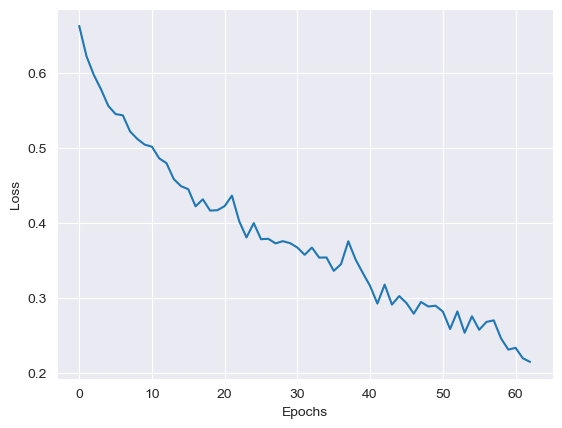

 97%|█████████████████████████████████████████▋ | 63/65 [00:31<00:01,  1.94it/s]

Epoch: 062, Loss: 0.21426


 98%|██████████████████████████████████████████▎| 64/65 [00:32<00:00,  1.95it/s]

Epoch: 063, Loss: 0.20626


100%|███████████████████████████████████████████| 65/65 [00:32<00:00,  1.97it/s]

Epoch: 064, Loss: 0.24216


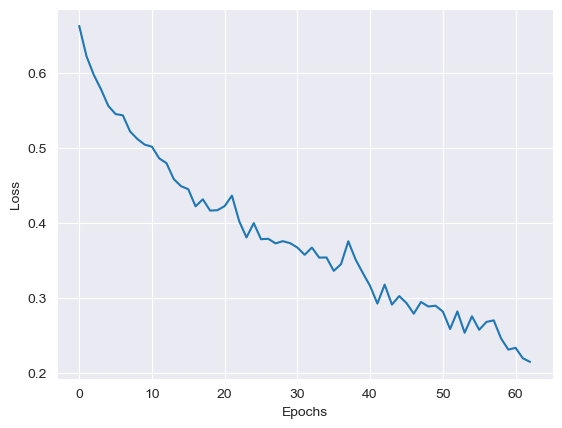

In [32]:
history = []
Y_train_hat = []
Y_train = []

num_epochs = 65

plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Epochs', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for epoch in tqdm(range(num_epochs)):
    model.train()
   

    loss_all = 0
    for data in train_loader:
    #for data in check_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        #Y_hat = output.max(dim=1)
        #print(output, data.y)
        Y_train_hat.append(output)       
        
        Y_batch = F.one_hot(data.y, num_classes=2)
        Y_batch = Y_batch.float()
        Y_train.append(Y_batch)
        #print("Y type:", data.y.dtype, "\tY shape:", data.y.shape)
        #print("Y type:", Y_batch.dtype, "\tY shape:", Y_batch.shape)
        #print("Y_hat type:", output.dtype, "\tY_hat shape:", output.shape)
        #print("Target (Y):", Y_batch)
                
        #print(output, data.y)       
        loss = F.binary_cross_entropy(output, Y_batch)
        #loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()        
        optimizer.step()
        
    #loss = loss_all / len(data_list[n:])
    loss = loss_all / len(train_fold) 
    history.append(loss)   
    plotter.plot(history)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.5f}')

In [33]:
# #For Debugging. Check Epoch wise Predicted output

# num_batches = len(Y_train)/num_epochs #counter for the number of epochs. 

# batch = 0
# e = 0

# for i in range(len(Y_train)):
#     #pre = Y_train_hat[i].max(dim=1)[1]
#     #obs =  Y_train[i].max(dim=1)[1]
#     if batch == num_batches:
#         batch = 0
#         e += 1
#     if e == num_epochs:
#         e = 0
#     #print("Epoch %d Batch %d: " %(e, batch), "\n", Y_train_hat[i].max(dim=1)[1].tolist(), "\n", Y_train[i].max(dim=1)[1].tolist(), "\n\n")
#     batch +=1
    
#     #print(pre.tolist(), obs.tolist())

In [34]:
#Debug test
#30.11.2022 - it's working correctly.
#01.12.2022 - check why all outputs are predicted 1. 
model.eval()
correct = 0
Y_target = []
Y_hat = []
Y_probas = []
#loader = train_loader
loader = test_loader
print("No. of samples:", len(loader.dataset))    
for data in loader:
    data = data.to(device)
    #max of a torch tensor returns a tuple (values, indices)
    probas = model(data).max(dim=1)[0] #return the maximum value, ie probability
    pred = model(data).max(dim=1)[1] #return index of the maximum value
    #Y_target.append(data.y.tolist())
    Y_target.append(data.y.detach().cpu().numpy())
    #Y_hat.append(pred.tolist())
    Y_hat.append(pred.detach().cpu().numpy())
    #Y_probas.append(probas.tolist())
    Y_probas.append(probas.detach().cpu().numpy())
    #print(pred.tolist(), data.y.tolist())
    correct += pred.eq(data.y).sum().item()
    

No. of samples: 62


In [35]:
Y_target = np.concatenate(Y_target, axis=0)
Y_hat = np.concatenate(Y_hat, axis =0)
Y_probas = np.concatenate(Y_probas, axis=0)

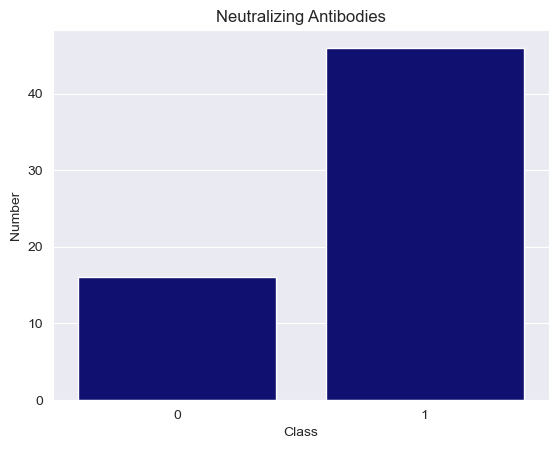

In [36]:
# for i in range(len(Y_target)):
#       print(Y_target[i], Y_hat[i])



p2 = sns.countplot(x=Y_target, color='navy').set(title='Neutralizing Antibodies', ylabel= 'Number', xlabel='Class')

In [37]:
print("No. of correct Predictions: %d of %d" %(correct, len(loader.dataset)))
print("Accuracy is: %.5f" %(correct/len(loader.dataset)))

No. of correct Predictions: 42 of 62
Accuracy is: 0.67742


In [38]:
#Performance Metrics

Conf = confusion_matrix(Y_target, Y_hat)
Sensitivity = recall_score(Y_target, Y_hat) *100
F1 = f1_score(Y_target, Y_hat) * 100
mcc = matthews_corrcoef(Y_target, Y_hat)
acc = accuracy_score(Y_target, Y_hat) * 100
pre = precision_score(Y_target, Y_hat) * 100
Specificity = Conf[0][0]/(Conf[0][0]+Conf[0][1]) * 100
ROC = roc_auc_score(Y_target, Y_hat) * 100 #average='weighted'. default = 'macro'
print( "SN = %.3f  SP = %.3f  PR= %.3f ACC = %.3f  F1 = %.3f  MCC = %.3f \n"%(Sensitivity, Specificity, pre, acc, F1, mcc))
print("ROC AUC = %.3f\n" %(ROC))
print(Conf)
#Conf[0][1]


SN = 86.957  SP = 12.500  PR= 74.074 ACC = 67.742  F1 = 80.000  MCC = -0.007 

ROC AUC = 49.728

[[ 2 14]
 [ 6 40]]


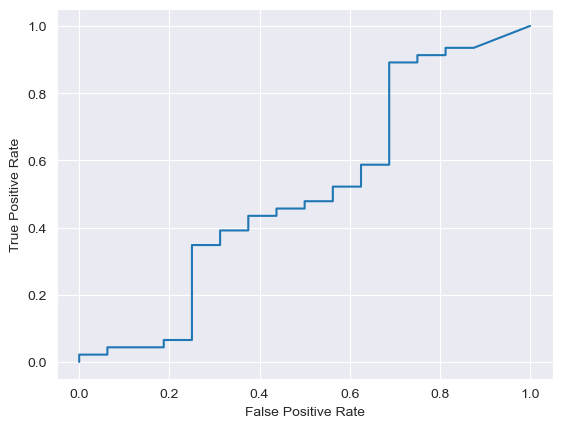

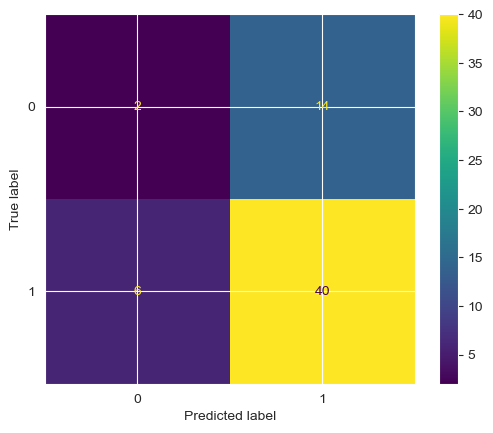

In [39]:
#plot the ROC Curve
fpr, tpr, thresholds = roc_curve(Y_target, Y_probas)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
cm_display = ConfusionMatrixDisplay(Conf).plot() #cmap='Oranges'
plt.savefig('ConfusionMatrix_GCN.png')